# The Measurements and Visualizations of PorkCNN with TensorBoard

author: davidycliao(David Yen-Chieh Liao)                                                                      
email: davidycliao@gmail.com                                                             
date: 9-July-2021  

-------------------------

### Stage 1: Libaries & Dependencies

In [1]:
# built-in library
import math
import re
import collections
import zipfile
import random
from itertools import chain

# ML & Deep Learning/ NLP toolkit
import pandas as pd
import numpy as np
import jieba
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

-------------------------

### Stage 2: Data Preprocessing (Training Data: Introduction of Bills and Legislation from 6th Session to 7th Session, 2004-2012)

#### (1) Read file 

In [2]:
# read file
df = pd.read_csv('data/Pork Bill - 2021-05-20.csv',encoding='utf-8')

# combine abstract of bill and title 
df['text'] =  df['Title'] + df['Content'].fillna(df['Title'])

# drop conten without having any characters
# view na's row: df[df['text'].isnull()==True]
data = df[['text', 'pork_bill']].dropna(subset=['text'])

In [3]:
print(" Pork Legislation", data['pork_bill'].value_counts()[1],'\n', 
      "None-Pork Legislation", data['pork_bill'].value_counts()[0])

 Pork Legislation 2510 
 None-Pork Legislation 4733


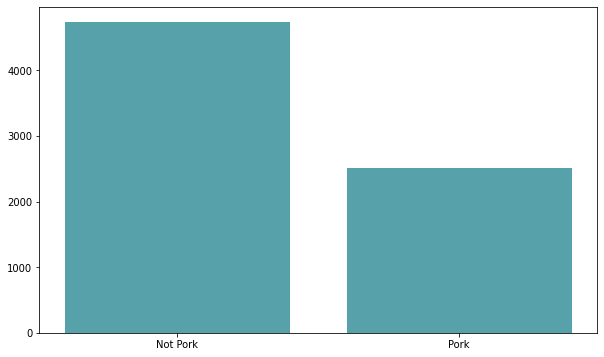

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
pork_plot = pd.DataFrame({"num":data['pork_bill'].value_counts(), "type":['Not Pork','Pork']})
plt.bar(pork_plot['type'], pork_plot['num'], color='#57A1AB')
#plt.show()
plt.savefig('images/full_plot.png')

#### (2) Tokenization

In [5]:
import collections
import numpy as np
import jieba
from itertools import chain


def jieba_cut(filename):
    """
    cut Chinese and remove stop words
    Reference: https://www.cnblogs.com/Luv-GEM/p/10836454.html
    Stopwords: https://www.kaggle.com/rikdifos/english-and-chinese-stopwords?select=cn_stopwords.txt
    """
    stop_list = [i.strip() for i in open('cn_stopwords.txt','r',encoding='utf-8')]  
    news_cut = []
    news_list = []
    for line in filename:    
        if line:
            news_cut = list(jieba.cut(''.join(line),cut_all=False,HMM=True))  
            news_list.append([word.strip() for word in news_cut if word not in stop_list and len(word.strip())>0]) 
    news_list = list(chain.from_iterable(news_list))  
    return news_list

def clearPucts(context):
    """
    remove punctuation
    ref: https://chenyuzuoo.github.io/posts/28001/
    """
    context = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "", context)
    context = re.sub("[【】╮╯▽╰╭★→「」]+","", context)
    context = re.sub("！，❤。～《》：（）【】「」？”“；：、","",context)
    context = re.sub("\s","",context)
    return context

def seg_char(sent):
    """
    cut Chinese and remove stop words
    ref: https://blog.csdn.net/renyuanfang/article/details/86487367
    """
    # split
    pattern_char_1 = re.compile(r'([\W])')
    parts = pattern_char_1.split(sent)
    parts = [p for p in parts if len(p.strip())>0]
    # cut sentence
    pattern = re.compile(r'([\u4e00-\u9fa5])')
    chars = pattern.split(sent)
    chars = [w for w in chars if len(w.strip())>0]
    chars = ' '.join(chars)
    return chars

In [6]:
data_clean = [seg_char(text) for text in [clearPucts(text) for text in data.text]]

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    data_clean, target_vocab_size=2**18)

data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

#### (3) Padding

In [7]:
MAX_LEN = max([len(sentence) for sentence in data_clean])
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value=0,
                                                            padding="post",
                                                            maxlen=MAX_LEN)

print('Maximun length:{} \nInput:{}'.format(MAX_LEN, data_inputs.shape[0]))


Maximun length:785 
Input:7243


#### (4) Spliting Training / Testing Set

In [8]:
data_labels = data.pork_bill.values

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    data_inputs, data_labels, test_size=0.33, random_state=42)

print("Shape of X Train:", train_inputs.shape, '\n'
      "Shape of X Test :", test_inputs.shape,'\n'
      "Shape of Y Trian:", train_labels.shape , '\n'
      "Shape of Y Test :", test_labels.shape )

Shape of X Train: (4852, 785) 
Shape of X Test : (2391, 785) 
Shape of Y Trian: (4852,) 
Shape of Y Test : (2391,)


-------------------------


### Stage 3: Model and Building

#### (1) Using the Subclassing API to Build Dynamic Model

In [10]:
class DCNN(tf.keras.Model):
    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 nb_filters=100,
                 # units: Positive integer, dimensionality of the output space.
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="PorkCNN"):
        super(DCNN, self).__init__(name=name)
        self.embedding = layers.Embedding(vocab_size, emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, strides = 1, padding="valid", activation="relu")
        self.bigram2 = layers.Conv1D(filters=nb_filters, kernel_size=2, strides = 2, padding="valid", activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,kernel_size=3,strides = 1, padding="valid",activation="relu")
        self.trigram2 = layers.Conv1D(filters=nb_filters,kernel_size=3,strides = 2, padding="valid",activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,kernel_size=4,strides = 2, padding="valid",activation="relu")
        self.fivegram = layers.Conv1D(filters=nb_filters,kernel_size=5,strides = 2, padding="valid",activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.last_dense = layers.Dense(units=1, activation="sigmoid")    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_1_1 = self.bigram2(x)
        x_1_1 = self.pool(x_1_1)        
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_2_1 = self.trigram2(x)
        x_2_1 = self.pool(x_2_1)     
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)
        x_4 = self.fourgram(x)
        x_4 = self.pool(x_4) 
        x_5 = self.fivegram(x)
        x_5 = self.pool(x_5)      
        merged = tf.concat([x_1,x_1_1, x_2,x_2_1, x_3, x_4, x_5], axis=-1) 
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)        
        return output

In [11]:
VOCAB_SIZE = tokenizer.vocab_size #tokenizer.vocab_size  # 5000 tokenizer.vocab_size
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2 #len(set(train_labels))
DROPOUT_RATE = 0.25
BATCH_SIZE = 230
NB_EPOCHS = 1000

Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

#### (2) Compile and Summary of the Model

In [12]:
Dcnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
Dcnn.build(input_shape = (train_inputs.shape[1], EMB_DIM)) # (train_inputs.shape[1] , EMB_DIM)  (785 , EMB_DIM)
Dcnn.summary()

Model: "PorkCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  586600    
_________________________________________________________________
conv1d (Conv1D)              multiple                  40100     
_________________________________________________________________
conv1d_1 (Conv1D)            multiple                  40100     
_________________________________________________________________
conv1d_2 (Conv1D)            multiple                  60100     
_________________________________________________________________
conv1d_3 (Conv1D)            multiple                  60100     
_________________________________________________________________
conv1d_4 (Conv1D)            multiple                  80100     
_________________________________________________________________
conv1d_5 (Conv1D)            multiple                  1001

-------------------------

### Stage 4: Train the Model

#### (1) Set up the Check-point Path

In [13]:
checkpoint_path = "checkpoint_recode_tensorboard/ckpt_manager"

ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Checkpoint Located!!")

#### (2) Define the TensorBoard Callback
reference: https://www.tensorflow.org/tensorboard/get_started

In [14]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      write_images=True,
                                                      histogram_freq=1)


#### (3) Training the Model


In [15]:
Dcnn.fit(train_inputs, train_labels,
         vavlidation_data=(test_inputs, test_labels),
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS,
         callbacks=[tensorboard_callback])
ckpt_manager.save()

Epoch 1/1000
22/22 [==============================] - 39s 2s/step - loss: 0.6029 - accuracy: 0.6641 - val_loss: 0.5091 - val_accuracy: 0.7227
Epoch 2/1000
22/22 [==============================] - 37s 2s/step - loss: 0.3850 - accuracy: 0.8333 - val_loss: 0.2724 - val_accuracy: 0.8929
Epoch 3/1000
22/22 [==============================] - 47s 2s/step - loss: 0.1823 - accuracy: 0.9349 - val_loss: 0.1759 - val_accuracy: 0.9264
Epoch 4/1000
22/22 [==============================] - 43s 2s/step - loss: 0.0897 - accuracy: 0.9722 - val_loss: 0.1630 - val_accuracy: 0.9402
Epoch 5/1000
22/22 [==============================] - 40s 2s/step - loss: 0.0605 - accuracy: 0.9802 - val_loss: 0.1646 - val_accuracy: 0.9456
Epoch 6/1000
22/22 [==============================] - 42s 2s/step - loss: 0.0483 - accuracy: 0.9854 - val_loss: 0.1665 - val_accuracy: 0.9419
Epoch 7/1000
22/22 [==============================] - 42s 2s/step - loss: 0.0476 - accuracy: 0.9847 - val_loss: 0.1669 - val_accuracy: 0.9435
Epoch 

'checkpoint_recode_tensorboard/ckpt_manager/ckpt-1'

### Stage 5: Tensorboard

#### (1) Call Tensorboard from Local

In [16]:
%load_ext tensorboard

%tensorboard --logdir logs/fit

#### (2) Upload Pre-run Data to Tensorboard.dev


In [ ]:
tensorboard dev upload --logdir \
    'logs/fit'

#### (2) Re name


In [ ]:
tensorboard dev update-metadata --experiment_id ************** \
--name "PorkCNN 🐖🐖🐖" --description "A Small Project for Pork Barrel Legislation  Classification Using Convolutional Neural Networks"
